In [12]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [13]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

from statsmodels.tsa.stattools import adfuller

In [14]:
pwd

'c:\\Users\\moham\\OneDrive\\Desktop\\Research Project\\Codes'

In [212]:
data = pd.read_csv('C:/Users/moham/OneDrive/Desktop/Research Project/Codes/cbsl_tot_tax.csv')

In [213]:
data

,Year,Total Revenue
0,1990,67964
1,1991,76179
2,1992,85781
3,1993,98339
4,1994,110038
5,1995,136258
6,1996,146279
7,1997,165036
8,1998,175032
9,1999,195905


#General process of arima model
#1> Visualize the time series data
#2> Make the series data stationary
#3> Plot the Correlation and Auto Correlation charts
#4> Use the model to make predictions

Cleanse the data

In [214]:
#cleaning the data
data.columns=["Year","Tax Revenue"]
data.head()

,Year,Tax Revenue
0,1990,67964
1,1991,76179
2,1992,85781
3,1993,98339
4,1994,110038


In [215]:
data.dtypes

Year           int64
Tax Revenue    int64
dtype: object

In [216]:
#getting the mean of tax revenue ammount and fill it to null, if theres any
data["Tax Revenue"] = data["Tax Revenue"].astype("float64")
m=round(data["Tax Revenue"].mean(),2)
data["Tax Revenue"].fillna(m,inplace=True)

EDA

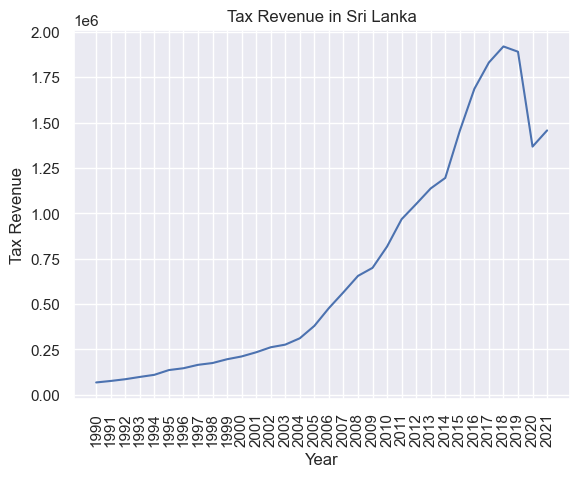

In [217]:
# Compute the number of years in the dataset
num_years = len(data['Year'])

# Set the x-axis ticks to represent each year
x_ticks = range(data['Year'][0], data['Year'][num_years - 1] + 1)

# Plot the data
plt.plot(data['Year'], data['Tax Revenue'])
plt.xticks(x_ticks, rotation='vertical')  # Set the x-axis ticks with yearly intervals
plt.xlabel('Year')
plt.ylabel('Tax Revenue')
plt.title('Tax Revenue in Sri Lanka')

# Display the plot
plt.show()


QUARTERLY DIVIDING THE DATA

In [218]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Assuming your yearly data is stored in a DataFrame called 'yearly_data' with columns
#Convert the "Year" column to datetime format

data[ 'Year'] = pd.to_datetime(data[ 'Year'], format='%Y')

#Set the "Year" column as the index

data.set_index('Year', inplace=True)


#Resample the data to quarterly frequency and interpolate missing values 
quarterly_data = data.resample('Q').mean().interpolate()

#Perform seasonal decomposition

result = seasonal_decompose(quarterly_data['Tax Revenue'], model="additive", period=4)

#Extract the trend, seasonal, and residual components

trend = result.trend 
seasonal =result.seasonal
residual =result.resid

#Create a DataFrame with the decomposed components
quarterly_decomposition = pd.DataFrame({'Trend': trend, 'Seasonal': seasonal, 'Residual': residual})

# Adjust the seasonal component to have the same length as the original data
adjusted_seasonal = quarterly_decomposition['Seasonal'].repeat(1)[:len(quarterly_data)]

# Subtract the adjusted seasonal component from the original data
adjusted_data = quarterly_data['Tax Revenue'] - adjusted_seasonal

# Create a DataFrame with the adjusted data
new_data = pd.DataFrame({'TaxRevenue_Adjusted': adjusted_data})




In [220]:
new_data.head()

,TaxRevenue_Adjusted
Year,
1990-03-31,68174.666667
1990-06-30,69975.616667
1990-09-30,71945.100000
1990-12-31,74083.116667
1991-03-31,76389.666667


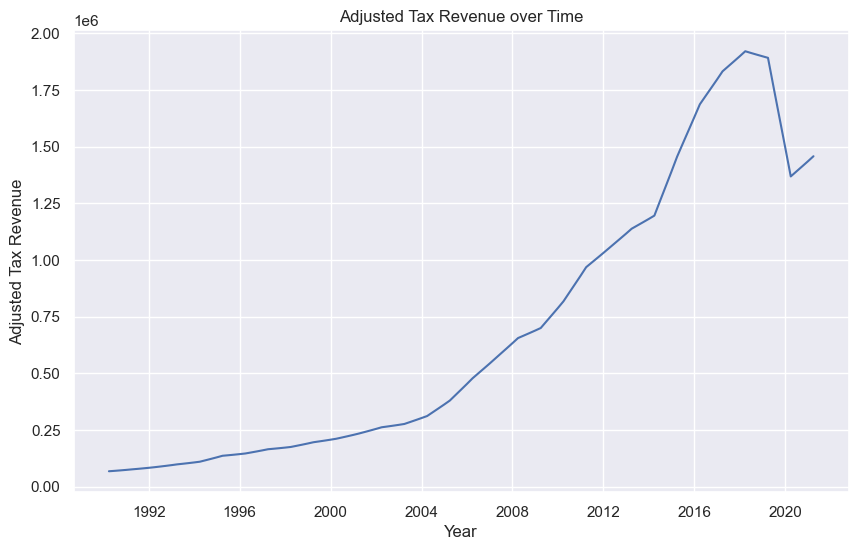

In [221]:
# Plot the adjusted tax revenue data
plt.figure(figsize=(10, 6))
plt.plot(adjusted_quarterly_data.index, new_data['TaxRevenue_Adjusted'])
plt.xlabel('Year')
plt.ylabel('Adjusted Tax Revenue')
plt.title('Adjusted Tax Revenue over Time')
plt.grid(True)
plt.show()

In [222]:
new_data.describe()

,TaxRevenue_Adjusted
count,1.250000e+02
mean,6.891373e+05
std,6.066889e+05
min,6.817467e+04
25%,1.724909e+05
50%,4.286631e+05
75%,1.151845e+06
max,1.920184e+06


Stationary check

In [223]:
test_result = adfuller(new_data['TaxRevenue_Adjusted'])

In [224]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Tax_revenue):
    result=adfuller(Tax_revenue)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [225]:
adfuller_test(new_data['TaxRevenue_Adjusted'])

ADF Test Statistic : -1.6694430445370996
p-value : 0.446921093549715
#Lags Used : 5
Number of Observations Used : 119
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Differencing

In [227]:
new_data['Tax revenue First Difference'] = new_data['TaxRevenue_Adjusted'] - new_data['TaxRevenue_Adjusted'].shift(1)

In [228]:
new_data['TaxRevenue_Adjusted'].shift(1)

Year
1990-03-31              NaN
1990-06-30              NaN
1990-09-30      1800.950000
1990-12-31      1969.483333
1991-03-31      2138.016667
                  ...      
2020-03-31   -130650.483333
2020-06-30   -130481.950000
2020-09-30     22024.950000
2020-12-31     22193.483333
2021-03-31     22362.016667
Freq: Q-DEC, Name: TaxRevenue_Adjusted, Length: 125, dtype: float64

In [250]:
new_data['Seasonal First Difference']=new_data['TaxRevenue_Adjusted']-new_data['TaxRevenue_Adjusted'].shift(14)

In [251]:
new_data.head(14)

,TaxRevenue_Adjusted,Tax revenue First Difference,Seasonal First Difference
Year,,,
1990-03-31,NaN,NaN,NaN
1990-06-30,1800.950000,NaN,NaN
1990-09-30,1969.483333,168.533333,NaN
1990-12-31,2138.016667,168.533333,NaN
1991-03-31,2306.550000,168.533333,NaN
1991-06-30,2147.700000,-158.850000,NaN
1991-09-30,2316.233333,168.533333,NaN
1991-12-31,2484.766667,168.533333,NaN
1992-03-31,2653.300000,168.533333,NaN


In [252]:
## Again test dickey fuller test
adfuller_test(new_data['Seasonal First Difference'].dropna())

ADF Test Statistic : -4.551419768335413
p-value : 0.00015859067824958086
#Lags Used : 13
Number of Observations Used : 96
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Auto Regressive Model

In [155]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

c:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
c:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


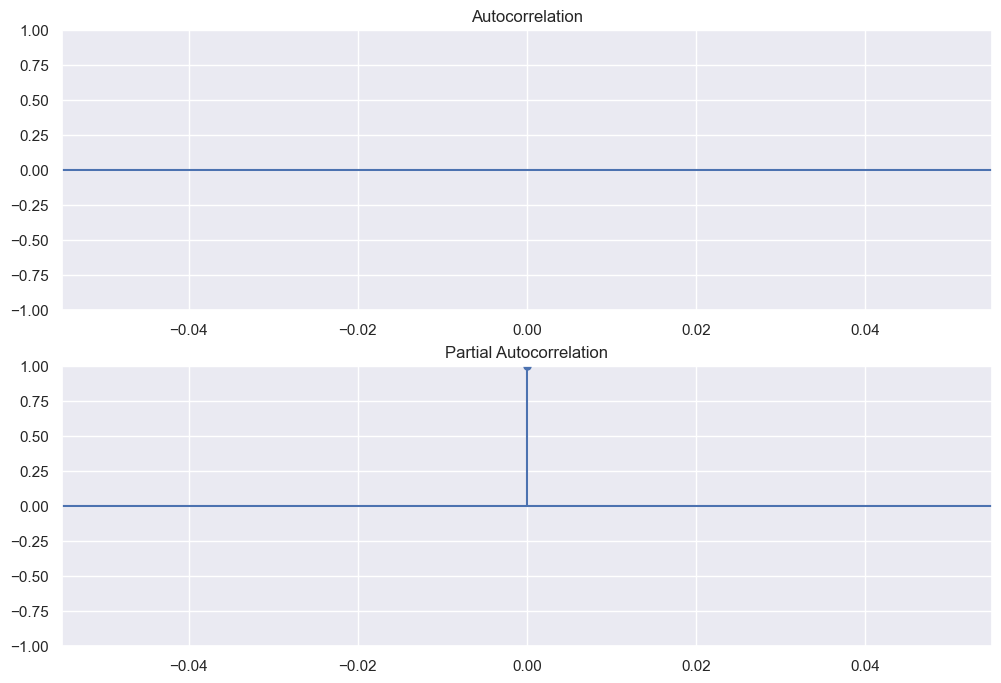

In [255]:
from statsmodels.tsa.arima.model import ARIMA

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(new_data['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(new_data['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [258]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA


In [259]:
model=ARIMA(new_data['TaxRevenue_Adjusted'],order=(1,1,1))
model_fit=model.fit()

In [260]:
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     TaxRevenue_Adjusted   No. Observations:                  125
Model:                  ARIMA(1, 1, 1)   Log Likelihood               -1392.363
Date:                 Sun, 21 May 2023   AIC                           2790.726
Time:                         23:49:53   BIC                           2799.187
Sample:                     03-31-1990   HQIC                          2794.163
                          - 03-31-2021                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8180      0.025     33.076      0.000       0.769       0.866
ma.L1         -0.9965      0.036    -28.038      0.000      -1.066      -0.927
sigma2      3.686e+08   9.22e-11      4e+18      0.000    3.69e+08    3.69e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):              7911.93
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):             774.91   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.48e+33. Standard errors may be unstable.
"""

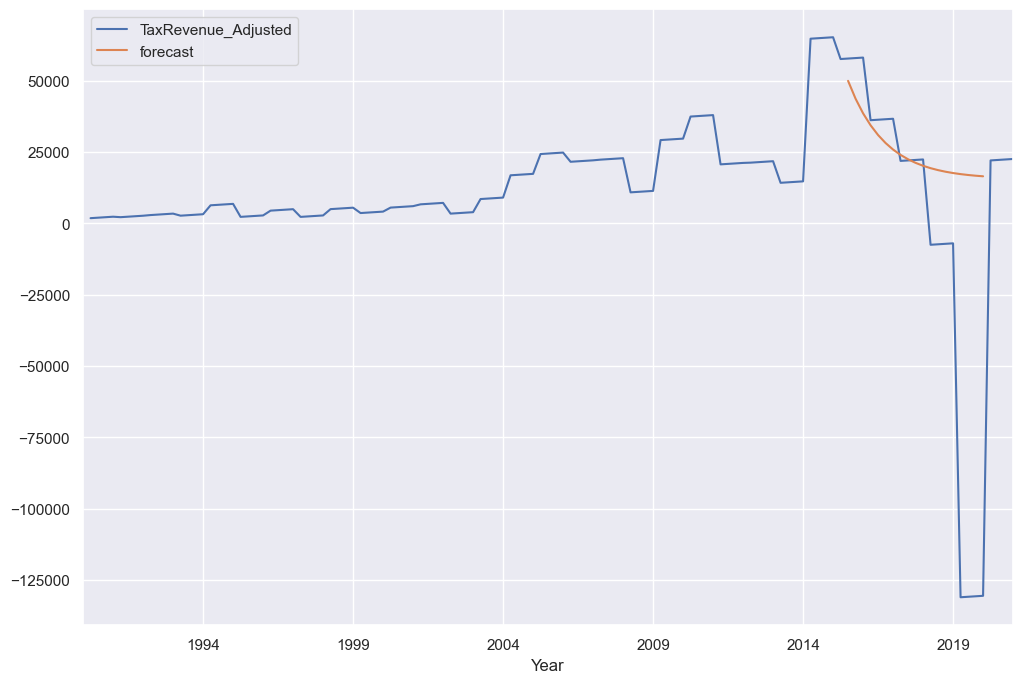

In [262]:
new_data['forecast'] = model_fit.predict(start = 102, end= 120, dynamic= True)  
new_data[['TaxRevenue_Adjusted', 'forecast']].plot(figsize=(12, 8))
plt.show()

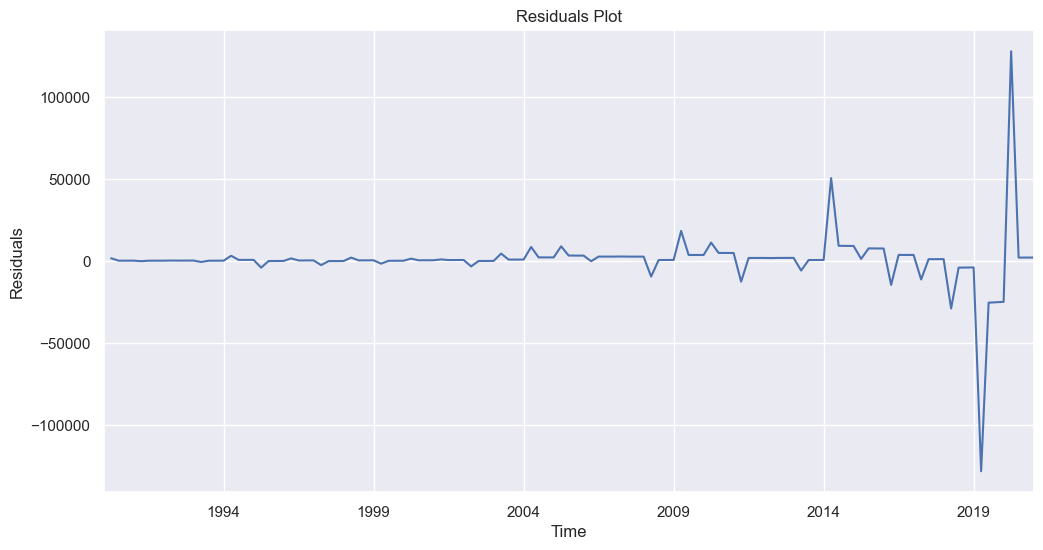

MAE: 5848.72437943014
RMSE: 17978.047409767056
Residuals Mean: 889.4196406559496
Residuals Variance: 322419121.3706475
Residuals Autocorrelation: 0.07678930563183897


In [266]:
# Assuming you have a pandas DataFrame called 'data' with a column called 'TimeSeriesData'
# and you have already fitted an ARIMA model to the data

# Obtain the model's predictions
model_predictions = model_fit.predict()

# Calculate residuals (errors) between the model's predictions and the actual values
residuals = new_data['TaxRevenue_Adjusted'] - model_predictions

# Perform residual analysis
# Plot residuals over time
residuals.plot(figsize=(12, 6))
plt.title('Residuals Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Calculate summary statistics of residuals
residuals_mean = np.mean(residuals)
residuals_variance = np.var(residuals)
residuals_autocorrelation = residuals.autocorr()

# Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))

print("MAE:", mae)
print("RMSE:", rmse)
print("Residuals Mean:", residuals_mean)
print("Residuals Variance:", residuals_variance)
print("Residuals Autocorrelation:", residuals_autocorrelation)


--------------------------------------------END OF ARIMA MODEL---------------------------------

Holt-Winters seasonal exponential smoothing

In [295]:
new_data.head()

,TaxRevenue_Adjusted,Tax revenue First Difference,Seasonal First Difference,forecast
Year,,,,
1990-03-31,NaN,NaN,NaN,NaN
1990-06-30,1800.950000,NaN,NaN,NaN
1990-09-30,1969.483333,168.533333,NaN,NaN
1990-12-31,2138.016667,168.533333,NaN,NaN
1991-03-31,2306.550000,168.533333,NaN,NaN


In [296]:
data.head()

,Tax Revenue
Year,
1990-01-01,67964.0
1991-01-01,76179.0
1992-01-01,85781.0
1993-01-01,98339.0
1994-01-01,110038.0


In [297]:
es_data = pd.read_csv('C:/Users/moham/OneDrive/Desktop/Research Project/Codes/cbsl_tot_tax.csv')

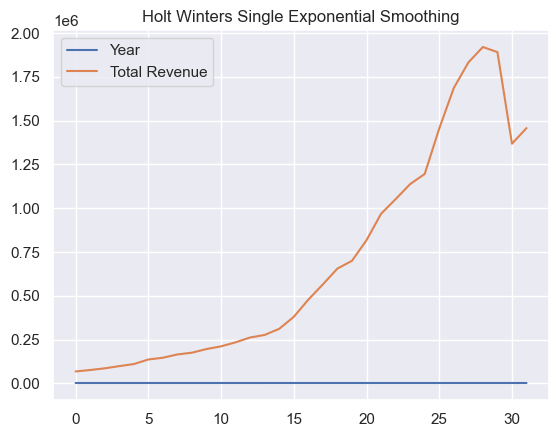

In [298]:
es_data[['Year','Total Revenue']].plot(title='Holt Winters Single Exponential Smoothing');

In [299]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [300]:
#getting the mean of tax revenue ammount and fill it to null, if theres any
es_data["Total Revenue"] = es_data["Total Revenue"].astype("float64")
m=round(es_data["Total Revenue"].mean(),2)
es_data["Total Revenue"].fillna(m,inplace=True)

In [301]:
es_data.head()

,Year,Total Revenue
0,1990,67964.0
1,1991,76179.0
2,1992,85781.0
3,1993,98339.0
4,1994,110038.0


In [302]:
#Assuming your yearly data is stored in a DataFrame called 'yearly_data' with columns
#Convert the "Year" column to datetime format

es_data[ 'Year'] = pd.to_datetime(es_data[ 'Year'], format='%Y')

#Set the "Year" column as the index

es_data.set_index('Year', inplace=True)


#Resample the data to quarterly frequency and interpolate missing values 
es_quarterly_data = es_data.resample('Q').mean().interpolate()

#Perform seasonal decomposition

result = seasonal_decompose(es_quarterly_data['Total Revenue'], model="additive", period=4)

#Extract the trend, seasonal, and residual components

es_trend = result.trend 
es_seasonal =result.seasonal
es_residual =result.resid

#Create a DataFrame with the decomposed components
es_quarterly_decomposition = pd.DataFrame({'Trend': trend, 'Seasonal': seasonal, 'Residual': residual})

# Adjust the seasonal component to have the same length as the original data
es_adjusted_seasonal = es_quarterly_decomposition['Seasonal'].repeat(1)[:len(es_quarterly_data)]

# Subtract the adjusted seasonal component from the original data
es_adjusted_data = es_quarterly_data['Total Revenue'] - es_adjusted_seasonal

# Create a DataFrame with the adjusted data
es_new_data = pd.DataFrame({'TaxRevenue_Adjusted': es_adjusted_data})

In [303]:
es_new_data.head()

,TaxRevenue_Adjusted
Year,
1990-03-31,68174.666667
1990-06-30,69975.616667
1990-09-30,71945.100000
1990-12-31,74083.116667
1991-03-31,76389.666667


In [304]:
# Split the dataset into training and test sets
train = es_new_data.iloc[:-5]
test = es_new_data.iloc[-5:]

In [306]:
# Create and fit the Holt-Winters seasonal exponential smoothing model
es_model = ExponentialSmoothing(train['TaxRevenue_Adjusted'], seasonal='add', seasonal_periods=12)
es_fitted_model = es_model.fit()

c:\Users\moham\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [307]:
# Perform forecasting for the next 5 years
es_forecast = es_fitted_model.forecast(5)

In [308]:
# Print the forecasted values
print(es_forecast)


2020-03-31    1.499587e+06
2020-06-30    1.498768e+06
2020-09-30    1.497834e+06
2020-12-31    1.496858e+06
2021-03-31    1.495764e+06
Freq: Q-DEC, dtype: float64


In [309]:
# Calculate error metrics
ep_mae = mean_absolute_error(test['TaxRevenue_Adjusted'], es_forecast)
ep_mse = mean_squared_error(test['TaxRevenue_Adjusted'], es_forecast)
ep_rmse = mean_squared_error(test['TaxRevenue_Adjusted'], es_forecast, squared=False)

# Print the error metrics
print("Mean Absolute Error (MAE):", ep_mae)
print("Mean Squared Error (MSE):", ep_mse)
print("Root Mean Squared Error (RMSE):", ep_rmse)

Mean Absolute Error (MAE): 85204.4687217033
Mean Squared Error (MSE): 8339425670.124095
Root Mean Squared Error (RMSE): 91320.45592376385


-----------END OF EXPONENTIAL SMOOTHING--------------------------------

TIME SERIES LSTM

In [312]:
rnn_data = pd.read_csv('C:/Users/moham/OneDrive/Desktop/Research Project/Codes/cbsl_tot_tax.csv') 

In [313]:
rnn_data.head()

,Year,Total Revenue
0,1990,67964
1,1991,76179
2,1992,85781
3,1993,98339
4,1994,110038


<AxesSubplot:xlabel='Year'>

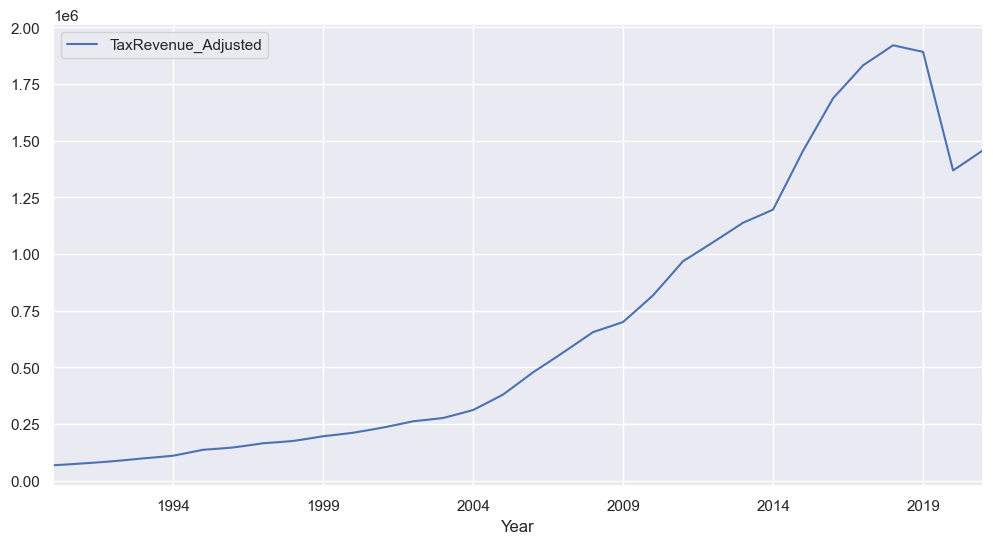

In [332]:

es_new_data.plot(figsize=(12,6))

Dividing quarterly -> done same work above, so using the same data

In [333]:
es_new_data.head()

,TaxRevenue_Adjusted
Year,
1990-03-31,68174.666667
1990-06-30,69975.616667
1990-09-30,71945.100000
1990-12-31,74083.116667
1991-03-31,76389.666667


<AxesSubplot:xlabel='Year'>

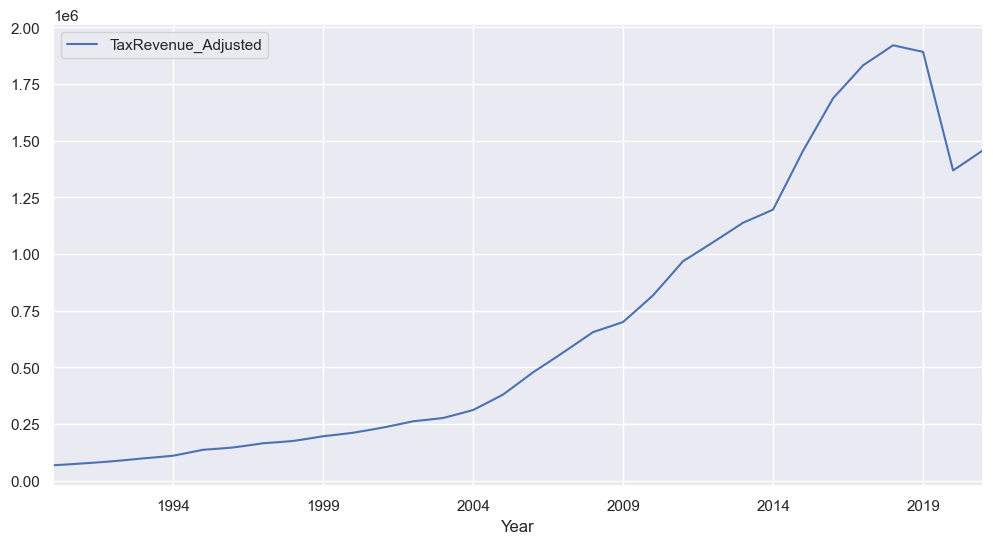

In [334]:
es_new_data.plot(figsize=(12,6))

In [318]:
from statsmodels.tsa.seasonal import seasonal_decompose

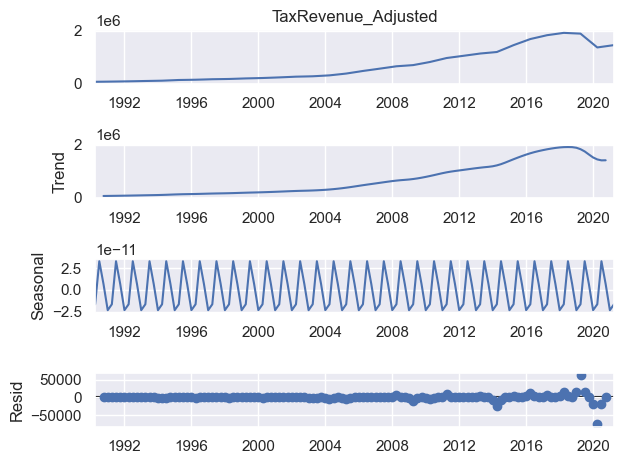

In [335]:
results = seasonal_decompose(es_new_data['TaxRevenue_Adjusted'])
results.plot();

In [336]:
len(es_new_data)

125

In [337]:
train = es_new_data.iloc[:113]
test = es_new_data.iloc[113:]

In [338]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [339]:

es_new_data.head(),es_new_data.tail()

(            TaxRevenue_Adjusted
 Year                           
 1990-03-31         68174.666667
 1990-06-30         69975.616667
 1990-09-30         71945.100000
 1990-12-31         74083.116667
 1991-03-31         76389.666667,
             TaxRevenue_Adjusted
 Year                           
 2020-03-31         1.368171e+06
 2020-06-30         1.390196e+06
 2020-09-30         1.412389e+06
 2020-12-31         1.434751e+06
 2021-03-31         1.457282e+06)

In [340]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [341]:
scaled_train[:10]

array([[0.        ],
       [0.00097243],
       [0.00203586],
       [0.00319029],
       [0.00443572],
       [0.00559538],
       [0.00684604],
       [0.0081877 ],
       [0.00962036],
       [0.01117905]])

In [345]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [346]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [347]:

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.00097243 0.00203586]
Predict this y: 
 [[0.00319029]]


In [348]:
X.shape
     

(1, 3, 1)

In [349]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [350]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [351]:

# define model
rnn_model = Sequential()
rnn_model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')

In [352]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [353]:
# fit model
rnn_model.fit(generator,epochs=50)

Epoch 1/50
101/101 [==============================] - 2s 4ms/step - loss: 0.0196
Epoch 2/50
101/101 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 3/50
101/101 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 4/50
101/101 [==============================] - 0s 3ms/step - loss: 9.5031e-04
Epoch 5/50
101/101 [==============================] - 0s 4ms/step - loss: 8.0853e-04
Epoch 6/50
101/101 [==============================] - 0s 4ms/step - loss: 7.9812e-04
Epoch 7/50
101/101 [==============================] - 0s 4ms/step - loss: 6.0664e-04
Epoch 8/50
101/101 [==============================] - 0s 4ms/step - loss: 6.2579e-04
Epoch 9/50
101/101 [==============================] - 0s 3ms/step - loss: 9.8567e-04
Epoch 10/50
101/101 [==============================] - 0s 4ms/step - loss: 6.5977e-04
Epoch 11/50
101/101 [==============================] - 0s 4ms/step - loss: 7.9245e-04
Epoch 12/50
101/101 [==============================] - 0s 4ms/step - loss: 

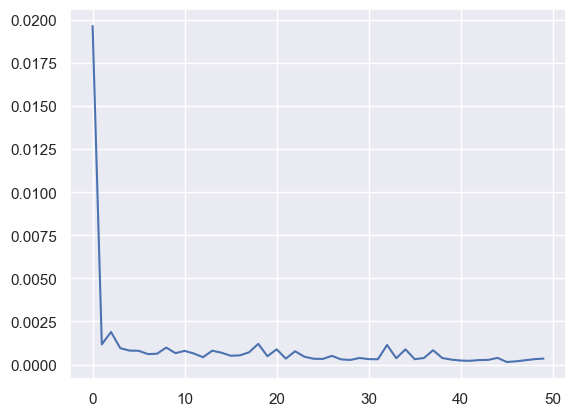

In [354]:
loss_per_epoch = rnn_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [355]:
last_train_batch = scaled_train[-12:]

In [356]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [357]:
rnn_model.predict(last_train_batch)

1/1 [==============================] - 0s 191ms/step


array([[1.0253358]], dtype=float32)

In [358]:
scaled_test[0]

array([0.99593884])

In [360]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = rnn_model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [361]:
test_predictions

[array([1.0253358], dtype=float32),
 array([1.0416743], dtype=float32),
 array([1.0586234], dtype=float32),
 array([1.0758075], dtype=float32),
 array([1.0930812], dtype=float32),
 array([1.109489], dtype=float32),
 array([1.1256658], dtype=float32),
 array([1.1414641], dtype=float32),
 array([1.1568235], dtype=float32),
 array([1.1716201], dtype=float32),
 array([1.1858513], dtype=float32),
 array([1.1994249], dtype=float32)]

In [362]:

test.head()

,TaxRevenue_Adjusted
Year,
2018-06-30,1.912662e+06
2018-09-30,1.905310e+06
2018-12-31,1.898125e+06
2019-03-31,1.891110e+06
2019-06-30,1.760122e+06


In [363]:
true_predictions = scaler.inverse_transform(test_predictions)

In [364]:

test['Predictions'] = true_predictions

C:\Users\moham\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [365]:
test.head()

,TaxRevenue_Adjusted,Predictions
Year,,
2018-06-30,1.912662e+06,1.967106e+06
2018-09-30,1.905310e+06,1.997365e+06
2018-12-31,1.898125e+06,2.028755e+06
2019-03-31,1.891110e+06,2.060580e+06
2019-06-30,1.760122e+06,2.092571e+06


In [366]:
true_predictions = scaler.inverse_transform(test_predictions)

In [367]:

test['Predictions'] = true_predictions

C:\Users\moham\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Year'>

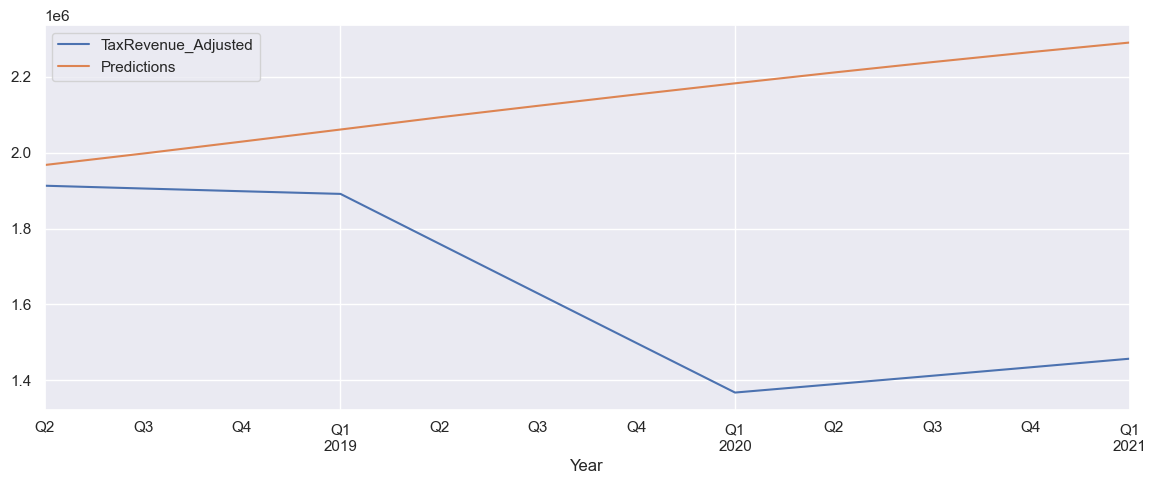

In [368]:
test.plot(figsize=(14,5))

In [373]:

from sklearn.metrics import mean_squared_error
from math import sqrt
rnn_rmse=sqrt(mean_squared_error(test['TaxRevenue_Adjusted'],test['Predictions']))
print("rmse :",rnn_rmse)
     

rmse : 594263.7332381648


-------------END OF LSTM----------------